In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Normalization
import numpy as np
from sklearn.model_selection import train_test_split,KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tf2onnx


In [5]:
# with open("b_values.json") as f:
#     b_values = json.load(f)
    
# with open("avg_amplitude_ratios.json") as f:
#     avg_amplitude_ratios = json.load(f)

with open("results.csv") as f:
    results = f.readlines()
    
strings = ["h_E", "B", "G", "D", "A", "E"]
labels = np.array([0,1,2,3,4,5])
# strings = ["1-2h_E", "1-2B", "1-2G", "1-2D", "1-2A", "1-2E", "2-2h_E", "2-2B", "2-2G", "2-2D", "2-2A", "2-2E"]
# labels = np.array([0,1,2,3,4,5,6,7,8,9,10,11])


data = []
label_list = []

for i, line in enumerate(results):
    if i == 0:
        continue
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        data.append([metric,amp_ra, deviation,f0])
        label_list.append(labels[strings.index(string)])


data = np.array(data, dtype=np.float32)
label_list = np.array(label_list)




label_count = 6
labels_categorical = tf.keras.utils.to_categorical(label_list, num_classes=label_count)


X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42, shuffle=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Convert your data to numpy arrays if they are not already
X = np.array(X_train)
y = np.array(y_train)

# Initialize lists to store the results
val_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 2)
print(f"Training labels shape: {y_train.shape}")

Training data shape: (1415, 4)
Training labels shape: (1415, 6)


In [6]:
#normalize data
normalization_layer = Normalization(input_shape=(X_train.shape[1],))
normalization_layer.adapt(X_train)

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model = Sequential([
    normalization_layer,
    Dense(55, activation='relu'),
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),
    Dense(55, activation='relu'),
    #Dense(55, activation='relu'),
    #Dense(55, activation='relu'),
    Dense(32, activation='relu'),
   
    Dense(label_count, activation='softmax')
])
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00008), metrics=['accuracy'])

# Train the model

print(model.summary())
#implement early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, epochs=500, batch_size=30, validation_split=0.2,callbacks=early_stopping)
    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 4)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 55)             │           275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55)             │           220 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,574 (21.78 KB)

 Trainable params: 5,455 (21.31 KB)

 Non-trainable params: 119 (480.00 B)

None
Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1901 - loss: 1.8952 - val_accuracy: 0.2933 - val_loss: 1.7579
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2258 - loss: 1.7874 - val_accuracy: 0.3428 - val_loss: 1.7318
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2735 - loss: 1.7320 - val_accuracy: 0.3958 - val_loss: 1.7001
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3315 - loss: 1.6129 - val_accuracy: 0.4629 - val_loss: 1.6630
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3382 - loss: 1.5767 - val_accuracy: 0.4947 - val_loss: 1.6219
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3892 - loss: 1.5128 - val_accuracy: 0.5265 - val_loss: 1.5747
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4124 - loss: 1.4574 - val_accuracy: 0.5336 - val_loss: 1.5251
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4250 - loss: 1.4530 - val_accuracy: 0.53

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


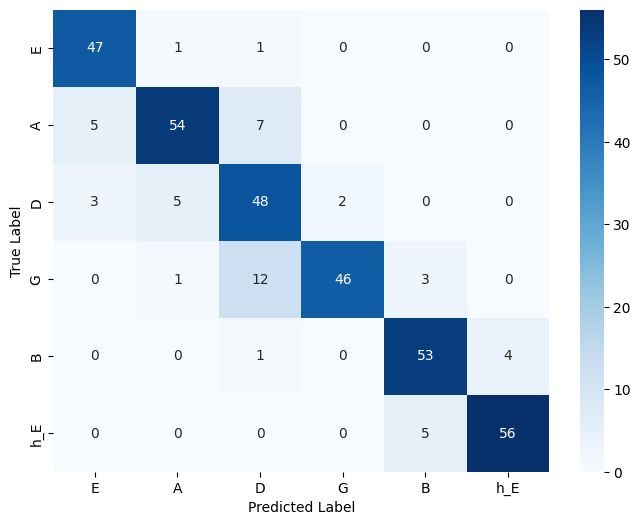

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

stringnames = ["E", "A", "D", "G", "B", "h_E"]
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=stringnames, yticklabels=stringnames)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
model.save('stringDetectionML.h5')

import os
from os import path
model.output_names=['output']
input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name='digit')]
print(model.inputs[0].shape) 
# Convert the Keras model to ONNX format
#onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)


(onnx_model_proto, storage) = tf2onnx.convert.from_keras(model,input_signature=input_signature, opset=13)

dir = os.getcwd()
dir = dir.split("/")[0]
while( path.basename(dir) != "TabGenerator"): # go to the TabGenerator directory
    dir = os.path.dirname(dir)

dir = os.path.join(dir, "Assets","MachineLearning","MLModels")
onnxpath = os.path.join(dir, "stringDetectionML_ONNX.onnx")

with open(onnxpath, "wb") as f:
    f.write(onnx_model_proto.SerializeToString())

(None, 4)
